In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ../setup_notebook.ipynb

In [2]:
# general imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors
import seaborn as sns
from subsets_analysis import Subsets
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from run_functions import filter_trials, dprime_tanke, spiral_tstart
import time
from scipy.optimize import curve_fit

In [3]:
# notebook specific imports
import pickle
import utils_funcs as utils
import re

In [4]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.markersize': 15}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

%matplotlib inline

In [5]:
figure_path = '/home/jrowland/mnt/qnap/Figures'

In [6]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'RL070', 'run_numbers': [22,23,24,27,28,29], 'runs': []},
{'mouse_id': 'RL072', 'run_numbers': [19,20,21,24], 'runs': []},
    
]

In [7]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [11]:
 def get_binned_licks(run, tstarts):
        
    ''' Replaces the 'binned_licks' function in opto_stim_import2.py as this
        function uses pyc tstart, not the x galvo tstart
        '''
    licks = run.session.times.get('lick_1')
    binned_licks = []
    for i, t_start in enumerate(tstarts):

        # Prevent index error on last trial
        if i == len(tstarts)-1:
            t_end = np.inf
        else:
            t_end = tstarts[i+1]

        #find the licks occuring in each trial
        trial_idx = np.where((licks>=t_start) & (licks<=t_end))[0]

        #normalise to time of trial start
        trial_licks = licks[trial_idx] - t_start

        binned_licks.append(trial_licks)

    return binned_licks

In [12]:
# for mouse_dict in mice_dicts:
#     for run_number, run in zip(mouse_dict['run_numbers'], mouse_dict['runs']):
#         run = spiral_tstart(run)

In [13]:
# all_diffs = []
# for mouse_dict in mice_dicts:
#     for run_number, run in zip(mouse_dict['run_numbers'], mouse_dict['runs']):
#         tstart_diff = spiral_tstart(run, diff_calc=True)
#         all_diffs.append(tstart_diff)
        

In [14]:
for mouse_dict in mice_dicts:
    for run_number, run in zip(mouse_dict['run_numbers'], mouse_dict['runs']):
        run.spiral_licks = get_binned_licks(run, run.aligner.B_to_A(run.spiral_start))

In [15]:
def get_month(run):
    return run.session.datetime.strftime('%Y-%m')

In [16]:
months = []
for mouse_dict in mice_dicts:
    for run_number, run in zip(mouse_dict['run_numbers'], mouse_dict['runs']):
        months.append(get_month(run))

In [17]:
months_set = np.sort(np.unique(months))
month_sorted = [[] for _ in range(len(months_set))]

for i, month in enumerate(months):
    sorted_idx = np.where(months_set==month)[0][0]
    month_sorted[sorted_idx].extend(all_diffs[i])
    
month_sorted = np.array(month_sorted)
month_sorted = [np.array(ms) for ms in month_sorted]

NameError: name 'all_diffs' is not defined

In [18]:
thresh = 250
above = [(sum(ms > thresh) / len(ms)) * 100 for ms in month_sorted]
plt.plot(months_set, above)
plt.xlabel('Month')
plt.ylabel('% of trials\nwith onset jitter > {} ms'.format(thresh))

TypeError: '>' not supported between instances of 'list' and 'int'

In [19]:
thresh = 250
above = [(sum(ms > thresh) / len(ms)) * 100 for ms in month_sorted]
plt.plot(months_set, above)
plt.xlabel('Month')
plt.ylabel('% of trials\nwith onset jitter > {} ms'.format(thresh))

TypeError: '>' not supported between instances of 'list' and 'int'

In [20]:
flattened = np.concatenate(all_diffs).ravel()
bins = np.arange(0,1500,50)
h = plt.hist(flattened, bins=bins)
plt.xlabel('Jitter to trial onset (ms)')
plt.ylim((0,10))
#plt.xlim((0,200))

NameError: name 'all_diffs' is not defined

In [21]:
def trial_outcomes(outcome):

    go_outcome = []
    nogo_outcome = []

    for t in outcome:
        if t == 'hit':
            go_outcome.append(True)
        elif t == 'miss':
            go_outcome.append(False)
        elif t =='cr':
            nogo_outcome.append(False)
        elif t == 'fp':
            nogo_outcome.append(True)

    go_outcome = np.array(go_outcome)
    nogo_outcome = np.array(nogo_outcome)
    
    return go_outcome, nogo_outcome

In [22]:
def get_subset_dprime(run, good=True):
    
    ''' get the d-prime for each subset in a run.
        Returns nan if < 10 trials of a subset in a session
        '''

    if good:
        trial_idxs = filter_trials(run)
    else:
        trial_idxs = np.arange(len(run.outcome))
        
    outcome = np.array(run.outcome)[trial_idxs]
    trial_info = np.array(run.trial_info)[trial_idxs]
    assert len(outcome) == len(trial_info)
    print('{}% of trials good'.format(round(sum(trial_idxs) / len(trial_idxs) * 100), 2))
    
    go_outcome, nogo_outcome = trial_outcomes(outcome)
    trial_subsets = []
    
    for i, info in enumerate(trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    group_dict = {
        0: '0',
        5: '5-10',
        10: '5-10',
        20: '20-30',
        30: '20-30',
        40: '40-50',
        50: '40-50',
        150: '150'
    }
    
    trial_subsets = [group_dict[sub] for sub in trial_subsets]
    trial_subsets = np.array(trial_subsets)
    subsets = ['0', '5-10', '20-30', '40-50', '150']
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    subset_rate = []
        
    assert len(go_outcome) == len(trial_subsets), '{} {}'.format(len(trial_subsets), len(go_outcome))
    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        if len(subset_idx) < 10:
            subset_rate.append(np.nan)
        else:
            subset_rate.append(sum(go_outcome[subset_idx]) / len(subset_idx))

    subsets_dprime = [utils.d_prime(rate, fp_rate) for rate in subset_rate]
    #subsets_dprime = subset_rate
    return subsets, subsets_dprime, fp_rate
    

In [23]:
def get_psychometric(runs, good=True):
    
    across_sessions = []
    fp_rates = []

    
    for run in runs:
        n_hits = len(np.where(run.outcome=='hit')[0])
        n_go = len(np.where(np.array(run.trial_type)=='go')[0])
        session_hitrate = n_hits / n_go
        session_fprate = len(np.where(run.outcome=='fp')[0]) / (len(run.outcome) - n_go)
        
        session_dprime = utils.d_prime(session_hitrate, session_fprate)
        
        if session_dprime < 0.6:
            continue
        
        global subsets  # hackkkkkkk
        subsets, subsets_dprime, fp_rate = get_subset_dprime(run, good=good)

        across_sessions.append(subsets_dprime)
        fp_rates.append(fp_rate)

    across_sessions = np.array(across_sessions)   
    meaned = np.nanmean(across_sessions, 0)
    
    # Currently returning mean of fp rate to avoid
    # session speicific info in dict
    return meaned, np.mean(fp_rates)

In [24]:
for mouse_dict in mice_dicts:
    dprimes, fp_rate = get_psychometric(mouse_dict['runs'], good=True)
    mouse_dict['dprimes'] = dprimes
    mouse_dict['fp_rate'] = fp_rate

across_mice = np.array([mouse_dict['dprimes'] for mouse_dict in mice_dicts])

53% of trials good
53% of trials good
46% of trials good
65% of trials good
69% of trials good
33% of trials good
37% of trials good
43% of trials good
71% of trials good
70% of trials good
86% of trials good
69% of trials good
58% of trials good
48% of trials good
79% of trials good
55% of trials good
81% of trials good
55% of trials good
71% of trials good
66% of trials good
56% of trials good
63% of trials good
60% of trials good
62% of trials good
55% of trials good
30% of trials good
46% of trials good
59% of trials good


In [25]:
def func(x, a, b, c, d):
    return a*x**3 + b*x**2 +c*x + d

ValueError: array must not contain infs or NaNs

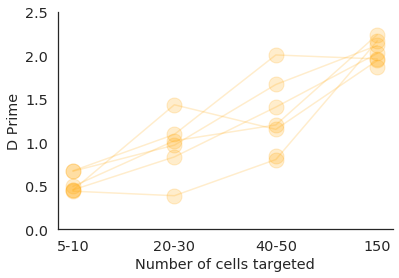

In [26]:
plt.figure()
y_min = 0
y_max = 2.5
my_color = 'orange'


x = np.arange(1,5)
plot_idx = 0
for mouse_dict in mice_dicts:
    plt.plot(subsets, mouse_dict['dprimes'], '.', markersize=30, color=my_color, alpha=0.2)
    popt, pcov = curve_fit(func, x, mouse_dict['dprimes'][1:])
    plt.plot(x, func(x, *popt), zorder=0, color=my_color, alpha=0.2) 
    plt.xlabel('Number of cells targeted')
    plt.ylabel('D Prime')
    plt.ylim((y_min, y_max))
    
meaned = np.nanmean(across_mice, 0)
popt, pcov = curve_fit(func, x, meaned[1:])

plt.plot(subsets, np.nanmean(across_mice, 0), '.', markersize=30, color=my_color)
plt.plot(x, func(x, *popt), zorder=0, color=my_color) 
plt.xlabel('Number of Cells Targeted')
plt.ylabel('D Prime')
plt.ylim((y_min, y_max))
plt.savefig(os.path.join(figure_path, 'easyTestPsychometrics.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'easyTestPsychometrics.png'),bbox_inches="tight")

In [27]:
def trial_binner(arr):
    
    group_dict = {
        
        0: '0',
        5: '5-10',
        10: '5-10',
        20: '20-30',
        30: '20-30',
        40: '40-50',
        50: '40-50',
        150: '150'
        
    }

    return np.array([group_dict[a] for a in arr])

In [28]:
def lick_raster(run, grid, run_number, only_good=False):
    
    binned_licks = np.array(run.spiral_licks)
    trial_type = np.array(run.trial_type)
    trial_subsets = Subsets(run).trial_subsets
    outcome = run.outcome
    
    # Do you only want to plot good trials?
    if only_good:
        good_idxs = filter_trials(run)
        binned_licks = binned_licks[good_idxs]
        trial_type = trial_type[good_idxs]
        trial_subsets = trial_subsets[good_idxs]
        outcome = outcome[good_idxs]

    assert len(binned_licks) == len(trial_type) == len(trial_subsets) == len(outcome), \
    '{} {} {} {}'.format(len(binned_licks), len(trial_type), len(trial_subsets), len(outcome))
    
    # Sort variables by whether the number of cells stimmed
    trial_idxs = np.argsort(trial_subsets, kind='mergesort')
    
    sorted_licks = binned_licks[trial_idxs]
    sorted_outcome = outcome[trial_idxs]
    sorted_subsets = trial_subsets[trial_idxs]
    sorted_subsets = trial_binner(sorted_subsets)
    
    # Map a plot color to each subset size
    #colors = ['black', 'dimgrey', 'darkgrey', 'silver', 'pink']
    colors = ['pink'] * 4
    colors.append('c')
    subsets = ['150', '40-50', '20-30', '5-10', '0']

    color_map = {}
    for i, sub in enumerate(subsets):
        color_map[sub] = colors[i] 
    subset_colors = [color_map[i] for i in sorted_subsets]
    
    # Init the parent figure 
    #fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, grid, width_ratios=[4, 1]) 
    #gs.update(wspace=0) # set the spacing between axes. 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    # Plot lick rasters 
    line_pos = []
    global reaction_times
    reaction_times = []
    for i, rast in enumerate(sorted_licks):

        color=subset_colors[i]
        y_axis = np.ones(len(rast)) + i

        if sorted_subsets[i] != sorted_subsets[i-1] and i != 0:
            ax0.axhline(y=i, ls='--', color='black')
            line_pos.append(i)
        try:
            point = rast[0] / 1000
            if point <= 1:
                marker = '.'
                fillstyle = 'full'
            else:
                marker = '.'
                fillstyle = 'none'
            ax0.plot(point, y_axis[0], marker=marker,
                     fillstyle=fillstyle, c=color, markersize=12)
            reaction_times.append(rast[0])
        except IndexError:
            reaction_times.append(np.nan)
            pass
            

    # Get positions of dividing lines so know where to put y tick labels
    line_pos.insert(0,0)
    line_pos.append(len(sorted_subsets))
    subset_centre = [(line_pos[i] + line_pos[i+1]) / 2 for i in range(len(line_pos)-1)]
    
    # Calculate session performance metrics
    session_dprime = round(utils.d_prime(run.hit_rate, run.fp_rate),2)
    _, subsets_dprime, _ = get_subset_dprime(run, good=True)
    easygood_dp = round(subsets_dprime[-1], 2)
    _, subsets_dprime, _ = get_subset_dprime(run, good=False)
    easyall_dp = round(subsets_dprime[-1], 2)
    tanke_test = round(dprime_tanke(run), 2)
    
    # Setup raster axis 
    ax0.fill_between([0,1], 0, len(sorted_licks), color='gainsboro', alpha=0.5)
    ax0.set_xlim((0,2))
    ax0.set_xlabel('Time (s)')
    ax0.set_ylim((0,len(sorted_licks)+1))
    ax0.set_yticks(subset_centre)
    ax0.set_yticklabels(np.flip(subsets))
    ax0.set_ylabel('Number of Cells Stimulated')
    ax0.set_title('Run Number {0}\n'
                  'Session d-prime = {1}\n'
                  '150 cell d-prime (all trials) = {2}\n'
                  '40/50 cell dprimes (tanke excluded) = {3}'
                  .format(run_number, session_dprime, easyall_dp, tanke_test))
    sns.despine()
    
    # Map trial types to ints so can express as colormap
    int_map = {
        'hit': 3,
        'miss': 2,
        'fp': 1,
        'cr': 0
    }
    
    int_mapped = [int_map[out] for out in np.flip(sorted_outcome)]        
    bar_width = 10
    bar_data = np.stack([int_mapped for _ in range(bar_width)], axis=1)
    
    # Color the trial int array
    cols =  [mcolors.to_rgba('gold') ,mcolors.to_rgba('tomato'),
            mcolors.to_rgba('orchid') , mcolors.to_rgba('yellowgreen')]
    cols =  [mcolors.to_rgba('gold') ,mcolors.to_rgba('black'),
            mcolors.to_rgba('red') , mcolors.to_rgba('green')]
    cm = LinearSegmentedColormap.from_list('hit_miss', cols, N=4)
    
    # Build the colorbar
    im = ax1.imshow(bar_data, cmap=cm)
    ax1.set_xticks([])
    trial_scale = [0, len(sorted_outcome)]
    ax1.set_yticks(trial_scale)
    ax1.set_yticklabels([('#'+str(t)) for t in np.flip(trial_scale)])
    #ax1.set_axis_off()
    cbar = plt.colorbar(im)
    cbar.set_ticks([0.2,1.1,1.75,2.5])
    cbar.set_ticklabels(['Correct\nRejection', 'False\nPositive', 'Miss', 'Hit'])
    #plt.tight_layout(w_pad=0)
    
    return gs

81% of trials good
8750.0% of trials good


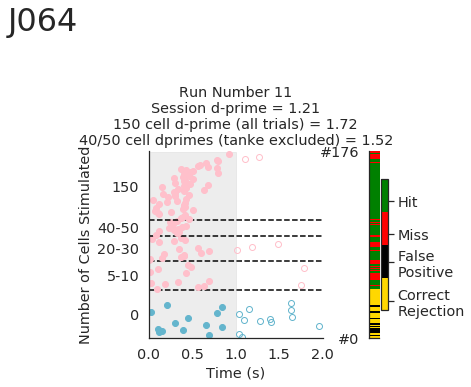

In [29]:
fig = plt.figure(figsize=(12,20), facecolor='white')
mouse_dict = mice_dicts[3]
outer = gridspec.GridSpec(4,2, hspace=0.6, wspace=0.8)


for i, run in enumerate(mouse_dict['runs']):
    if i ==1:
        gs = lick_raster(run, outer[i], mouse_dict['run_numbers'][i], only_good=False)
    

fig.suptitle(mouse_dict['mouse_id'], fontsize=32)
plt.savefig(os.path.join(figure_path, 'lickRasters.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'lickRasters.png'),bbox_inches="tight")